In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pathlib import Path
import sklearn
import einops
import pandas as pd
import numpy as np

import torch
device = torch.device("cuda")

NO_COMPRESS = False

shard_dir = "/homefs/home/lux70/storage/data/cath/shards"
cath_metadata_fpath = "/homefs/home/lux70/storage/data/cath/description/cath-domain-list-S35.txt"
ckpt_dir = "/homefs/home/lux70/storage/plaid/checkpoints/hourglass_vq/"

# Load inference model and data

## Load compression model

In [3]:
from plaid.compression.hourglass_vq import HourglassVQLightningModule
from plaid.esmfold import esmfold_v1

ckpt_dir = Path("/homefs/home/lux70/storage/plaid/checkpoints/hourglass_vq/")
compression_id = "8ebs7j9h"
ckpt_fpath = ckpt_dir / compression_id / "last.ckpt"
hourglass = HourglassVQLightningModule.load_from_checkpoint(ckpt_fpath)

hourglass.eval()
for param in hourglass.parameters():
    param.requires_grad_(False)

_ = hourglass.to(device)

using quantizer tanh


## Load CATH metadata

In [4]:
def load_cath_metadata(fpath):
    df = pd.read_csv(fpath, sep="\s+", header=None)
    
    # from the README file
    columns = [
        "cath_id", # original name: "CATH domain name (seven characters)",
        "Class number",
        "Architecture number",
        "Topology number",
        "Homologous superfamily number",
        "S35 sequence cluster number",
        "S60 sequence cluster number",
        "S95 sequence cluster number",
        "S100 sequence cluster number",
        "S100 sequence count number",
        "Domain length",
        "Structure resolution (Angstroms)"
    ]
    
    df.columns = columns
    return df

df = load_cath_metadata(cath_metadata_fpath)
df.head()

,cath_id,Class number,Architecture number,Topology number,Homologous superfamily number,S35 sequence cluster number,S60 sequence cluster number,S95 sequence cluster number,S100 sequence cluster number,S100 sequence count number,Domain length,Structure resolution (Angstroms)
0,1oaiA00,1,10,8,10,1,1,1,1,1,59,1.00
1,3frhA01,1,10,8,10,2,1,1,1,1,58,1.20
2,4g3oA00,1,10,8,10,3,1,1,1,1,53,1.60
3,4heoA00,1,10,8,10,4,1,1,1,1,53,1.65
4,1oksA00,1,10,8,10,5,1,1,1,1,51,1.80


## Load precomputed embeddings

In [5]:
from plaid.datasets import CATHShardedDataModule

# TODO: test with seq_len=512 with larger machine mem
dm = CATHShardedDataModule(
    shard_dir="/homefs/home/lux70/storage/data/cath/shards",
    seq_len=128,
)
dm.setup()

train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
batch = next(iter(train_dataloader))
print(len(train_dataloader.dataset))
print(len(val_dataloader.dataset))

25508
6377


In [6]:
from plaid.compression.hourglass_vq import HourglassVQLightningModule
from plaid.esmfold.misc import batch_encode_sequences
import torch
from tqdm.notebook import tqdm
import numpy as np


ckpt_dir = Path(ckpt_dir)
compression_id = "mm9fe6x9"
ckpt_fpath = ckpt_dir / compression_id / "last.ckpt"
hourglass = HourglassVQLightningModule.load_from_checkpoint(ckpt_fpath)
device = torch.device("cuda")


def collect_batches(dataloader, compress=True, in_df_only=True):
    sequences = []
    cath_ids = []
    
    all_x_c = []
    all_m_d = []

    print("dataset length:", len(dataloader.dataset))

    for batch in tqdm(dataloader):
        x, sequence, header = batch
        sequences.extend(sequence)
        cath_ids.extend(header)

        
        
        aatype, mask, _, _, _ = batch_encode_sequences(sequence)
    
        if not compress:
            x_c = x
            m_d = mask
        else:
            x = x.to(device)
            mask = mask.to(device)
            with torch.no_grad():
                x_c, m_d = hourglass(x, mask.bool(), infer_only=True)
        
        all_x_c.append(x_c.cpu().numpy())
        all_m_d.append(m_d.cpu().numpy())
    
    all_x_c = np.concatenate(all_x_c, axis=0)
    all_m_d = np.concatenate(all_m_d, axis=0)

    md_broadcast = einops.repeat(all_m_d, "n l -> n l c", c = all_x_c.shape[-1])
    xc_pooled = (all_x_c * md_broadcast).sum(axis=1) / md_broadcast.sum(axis=1)
    
    return {
        "x": all_x_c,
        "mask": all_m_d,
        "sequences": sequences,
        "cath_ids": cath_ids,
        "x_pooled": xc_pooled
    }

val_data = collect_batches(val_dataloader)
train_data = collect_batches(train_dataloader)

using quantizer tanh
dataset length: 6377


  0%|          | 0/200 [00:00<?, ?it/s]

dataset length: 25508


  0%|          | 0/798 [00:00<?, ?it/s]

# Join metadata with embeddings

In [7]:
# create an dataframe to make it easier to manipulate
train_embed_df = pd.DataFrame({"embedding_idx": np.arange(len(train_data['cath_ids'])), "cath_id": train_data['cath_ids']})
val_embed_df = pd.DataFrame({"embedding_idx": np.arange(len(val_data['cath_ids'])), "cath_id": val_data['cath_ids']})

# filter such that we only keep those with both metadata and cath_ids
print("Drop metadata without embedding")
train_df = df[df.cath_id.isin(train_data['cath_ids'])]
print("train dataset:", train_df.shape[0])

val_df = df[df.cath_id.isin(val_data['cath_ids'])]
print("val dataset:", val_df.shape[0])

# join the dataframes
train_df = train_df.set_index("cath_id").join(train_embed_df.set_index("cath_id"), how='left', rsuffix="embed_")
val_df = val_df.set_index("cath_id").join(val_embed_df.set_index("cath_id"), how='left', rsuffix="embed_")

train_df = train_df[~train_df.embedding_idx.isna()]
val_df = val_df[~val_df.embedding_idx.isna()]

print("Drop embeddings without metadata")
print("train dataset:", train_df.shape[0])
print("val dataset:", val_df.shape[0])

# reorder the pooled embedding
train_data['x_pooled_ordered'] = train_data['x_pooled'][train_df.embedding_idx.values]
val_data['x_pooled_ordered'] = val_data['x_pooled'][val_df.embedding_idx.values]

Drop metadata without embedding
train dataset: 15933
val dataset: 4033
Drop embeddings without metadata
train dataset: 15933
val dataset: 4033


In [8]:
print(train_data['x_pooled'][0])
print(train_data['x_pooled_ordered'][0])

[ 0.40865979 -0.2833091   0.28198171  0.01152713 -0.45496911 -0.54169446
 -0.49872667 -0.372794  ]
[ 0.41971493 -0.31094538  0.28804655  0.10000737 -0.47407427 -0.5235796
 -0.48918759 -0.36102826]


# Sanity check: TSNE

In [9]:
%%time

from sklearn.manifold import TSNE
import time

np.random.seed(42)

start = time.time()
tsne = TSNE()
tsne_emb = tsne.fit_transform(val_data['x_pooled_ordered'])
end = time.time()

print(f"{(end - start):.2f} seconds")

25.92 seconds
CPU times: user 26.3 s, sys: 1.19 ms, total: 26.3 s
Wall time: 26.2 s


In [10]:
val_df['tsne1'] = tsne_emb[:, 0]
val_df['tsne2'] = tsne_emb[:, 1]

<Axes: xlabel='tsne1', ylabel='tsne2'>

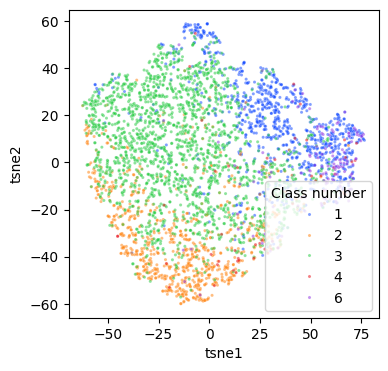

In [11]:
fig, ax = plt.subplots(figsize=(4,4),dpi=100)
sns.scatterplot(data=val_df, x='tsne1', y='tsne2', hue='Class number',s=5, palette="bright",alpha=0.5, ax=ax)

In [37]:
results = pd.DataFrame(
    {"compression_model_id": [],
    "shorten_factor:": [],
    "downprojection_factor": [],
    "n_neighbors": [],
    "pred_target": [],
    "acc": []}
)
results.head()

,compression_model_id,shorten_factor:,downprojection_factor,n_neighbors,pred_target,acc


# 5-NN: Class number

In [38]:
train_df.keys()

Index(['Class number', 'Architecture number', 'Topology number',
       'Homologous superfamily number', 'S35 sequence cluster number',
       'S60 sequence cluster number', 'S95 sequence cluster number',
       'S100 sequence cluster number', 'S100 sequence count number',
       'Domain length', 'Structure resolution (Angstroms)', 'embedding_idx'],
      dtype='object')

In [39]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X=train_data['x_pooled_ordered'], y=train_df['Class number'].values)

KNeighborsClassifier()

In [40]:
pred_classes = knn.predict(val_data['x_pooled_ordered'])

In [41]:
target = "Class number"
correct = (pred_classes == val_df[target].values).sum() / len(val_df)
correct

0.7731217455988099

In [42]:
row = pd.DataFrame(
    {"compression_model_id": [compression_id],
    "shorten_factor:": [hourglass.enc.shorten_factor],
    "downprojection_factor": [hourglass.enc.downproj_factor],
    "n_neighbors": [5],
    "pred_target": [target],
    "acc": [correct]}
)
row

,compression_model_id,shorten_factor:,downprojection_factor,n_neighbors,pred_target,acc
0,mm9fe6x9,2,128,5,Class number,0.773122


In [43]:
results = pd.concat([results, row])
results

,compression_model_id,shorten_factor:,downprojection_factor,n_neighbors,pred_target,acc
0,mm9fe6x9,2.0,128.0,5.0,Class number,0.773122


# 5-NN: architecture

In [44]:
%%time

target = "Architecture number"

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X=train_data['x_pooled_ordered'], y=train_df[target].values)

pred_classes = knn.predict(val_data['x_pooled_ordered'])

correct = (pred_classes == val_df[target].values).sum() / len(val_df)
correct

CPU times: user 252 ms, sys: 275 μs, total: 253 ms
Wall time: 252 ms


0.4673939995040913

In [46]:
row = pd.DataFrame(
    {"compression_model_id": [compression_id],
    "shorten_factor:": [hourglass.enc.shorten_factor],
    "downprojection_factor": [hourglass.enc.downproj_factor],
    "n_neighbors": [5],
    "pred_target": [target],
    "acc": [correct]}
)

results = pd.concat([results, row])
results

,compression_model_id,shorten_factor:,downprojection_factor,n_neighbors,pred_target,acc
0,mm9fe6x9,2.0,128.0,5.0,Class number,0.773122
0,mm9fe6x9,2.0,128.0,5.0,Architecture number,0.467394


# 5-NN: topology

In [47]:
%%time

target = "Topology number"

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X=train_data['x_pooled_ordered'], y=train_df[target].values)

pred_classes = knn.predict(val_data['x_pooled_ordered'])

correct = (pred_classes == val_df[target].values).sum() / len(val_df)
correct

CPU times: user 255 ms, sys: 570 μs, total: 256 ms
Wall time: 255 ms


0.2400198363501116

In [48]:
%%time

target = 'Homologous superfamily number'

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X=train_data['x_pooled_ordered'], y=train_df[target].values)

pred_classes = knn.predict(val_data['x_pooled_ordered'])

correct = (pred_classes == val_df[target].values).sum() / len(val_df)
correct

CPU times: user 253 ms, sys: 286 μs, total: 253 ms
Wall time: 252 ms


0.3607736176543516

In [49]:
row = pd.DataFrame(
    {"compression_model_id": [compression_id],
    "shorten_factor:": [hourglass.enc.shorten_factor],
    "downprojection_factor": [hourglass.enc.downproj_factor],
    "n_neighbors": [5],
    "pred_target": [target],
    "acc": [correct]}
)

results = pd.concat([results, row])
results

,compression_model_id,shorten_factor:,downprojection_factor,n_neighbors,pred_target,acc
0,mm9fe6x9,2.0,128.0,5.0,Class number,0.773122
0,mm9fe6x9,2.0,128.0,5.0,Architecture number,0.467394
0,mm9fe6x9,2.0,128.0,5.0,Homologous superfamily number,0.360774


# 1NN:

In [50]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)

In [52]:
%%time

target = "Class number"
knn.fit(X=train_data['x_pooled_ordered'], y=train_df[target].values)

pred_classes = knn.predict(val_data['x_pooled_ordered'])
correct = (pred_classes == val_df[target].values).sum() / len(val_df)
correct

CPU times: user 194 ms, sys: 159 μs, total: 194 ms
Wall time: 193 ms


0.7180758740391768

In [53]:
row = pd.DataFrame(
    {"compression_model_id": [compression_id],
    "shorten_factor:": [hourglass.enc.shorten_factor],
    "downprojection_factor": [hourglass.enc.downproj_factor],
    "n_neighbors": [1],
    "pred_target": [target],
    "acc": [correct]}
)

results = pd.concat([results, row])
results

,compression_model_id,shorten_factor:,downprojection_factor,n_neighbors,pred_target,acc
0,mm9fe6x9,2.0,128.0,5.0,Class number,0.773122
0,mm9fe6x9,2.0,128.0,5.0,Architecture number,0.467394
0,mm9fe6x9,2.0,128.0,5.0,Homologous superfamily number,0.360774
0,mm9fe6x9,2.0,128.0,1.0,Class number,0.718076


In [54]:
%%time

target = "Topology number"

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X=train_data['x_pooled_ordered'], y=train_df[target].values)

pred_classes = knn.predict(val_data['x_pooled_ordered'])

correct = (pred_classes == val_df[target].values).sum() / len(val_df)
correct

row = pd.DataFrame(
    {"compression_model_id": [compression_id],
    "shorten_factor:": [hourglass.enc.shorten_factor],
    "downprojection_factor": [hourglass.enc.downproj_factor],
    "n_neighbors": [1],
    "pred_target": [target],
    "acc": [correct]}
)

results = pd.concat([results, row])
results

CPU times: user 193 ms, sys: 384 μs, total: 194 ms
Wall time: 193 ms


,compression_model_id,shorten_factor:,downprojection_factor,n_neighbors,pred_target,acc
0,mm9fe6x9,2.0,128.0,5.0,Class number,0.773122
0,mm9fe6x9,2.0,128.0,5.0,Architecture number,0.467394
0,mm9fe6x9,2.0,128.0,5.0,Homologous superfamily number,0.360774
0,mm9fe6x9,2.0,128.0,1.0,Class number,0.718076
0,mm9fe6x9,2.0,128.0,1.0,Topology number,0.185718


In [55]:
%%time

target = 'Homologous superfamily number'

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X=train_data['x_pooled_ordered'], y=train_df[target].values)

pred_classes = knn.predict(val_data['x_pooled_ordered'])

correct = (pred_classes == val_df[target].values).sum() / len(val_df)


row = pd.DataFrame(
    {"compression_model_id": [compression_id],
    "shorten_factor:": [hourglass.enc.shorten_factor],
    "downprojection_factor": [hourglass.enc.downproj_factor],
    "n_neighbors": [1],
    "pred_target": [target],
    "acc": [correct]}
)

results = pd.concat([results, row])
results

CPU times: user 194 ms, sys: 0 ns, total: 194 ms
Wall time: 194 ms


,compression_model_id,shorten_factor:,downprojection_factor,n_neighbors,pred_target,acc
0,mm9fe6x9,2.0,128.0,5.0,Class number,0.773122
0,mm9fe6x9,2.0,128.0,5.0,Architecture number,0.467394
0,mm9fe6x9,2.0,128.0,5.0,Homologous superfamily number,0.360774
0,mm9fe6x9,2.0,128.0,1.0,Class number,0.718076
0,mm9fe6x9,2.0,128.0,1.0,Topology number,0.185718
0,mm9fe6x9,2.0,128.0,1.0,Homologous superfamily number,0.229358


In [56]:
results.to_csv(f"/homefs/home/lux70/storage/plaid/artifacts/eval/cath_knn/{compression_id}.csv", sep=",")